# 📊 Natural Disaster Prediction - Model Evaluation

## Big Data and Deep Learning-Based Natural Disaster Prediction Using Multi-Source Environmental Data

This notebook provides comprehensive evaluation and visualization of the trained disaster prediction model.

### Contents:
1. Load trained model and test data
2. Generate predictions
3. Classification metrics (accuracy, precision, recall, F1)
4. Confusion matrices
5. ROC and Precision-Recall curves
6. Feature importance analysis
7. Error analysis
8. Visualization of predictions

## 1. Setup and Imports

In [1]:
# Standard libraries
import os
import sys
import json
import warnings
from datetime import datetime

# Data processing
import numpy as np
import pandas as pd

# Deep Learning
import torch
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Sklearn metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.getcwd()) if 'notebooks' in os.getcwd() else os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/leonnn/Desktop/DL for disaster


In [2]:
# Import project modules
from configs.config import (
    get_config, DATA_PATH, MODEL_DIR, LOG_DIR,
    SATELLITE_FEATURES, WEATHER_FEATURES, STATIC_FEATURES
)
from src.dataset import (
    DisasterDataProcessor, create_dataloaders
)
from src.models import DisasterPredictionModel, create_model
from src.utils import (
    CheckpointManager, get_device, set_seed,
    plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
)

print("\n✅ All modules imported successfully!")


✅ All modules imported successfully!


## 2. Load Model and Data

In [3]:
# Configuration
config = get_config()
device = get_device()
set_seed(config.data.random_seed)

# Create model
model = create_model(config.model, device)

# Load best checkpoint
checkpoint_manager = CheckpointManager(
    model_dir=MODEL_DIR,
    experiment_name=config.experiment_name
)

try:
    checkpoint = checkpoint_manager.load(model)
    print(f"✅ Loaded model from epoch {checkpoint['epoch']}")
    print(f"   Best score: {checkpoint.get('best_score', 'N/A')}")
except FileNotFoundError:
    print("⚠️ No checkpoint found. Please train the model first.")

Using Apple Silicon MPS
Random seed set to 42

Model Parameter Summary:
  cnn_encoder: 126,720
  lstm_encoder: 743,041
  mlp_encoder: 25,536
  fusion: 148,736
  flood_head: 8,386
  drought_head: 8,386
  total: 1,060,805

Loaded checkpoint from /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_v1_best.pt (epoch 1)
✅ Loaded model from epoch 1
   Best score: 0.9468177420816117


In [4]:
# Load and preprocess data
processor = DisasterDataProcessor(config.data)

# Load preprocessors (fitted during training)
try:
    processor.load_preprocessors()
except FileNotFoundError:
    print("⚠️ Preprocessors not found. Running full preprocessing...")

# Process data
train_df, val_df, test_df = processor.process(DATA_PATH)

# Create test dataloader
_, _, test_loader = create_dataloaders(train_df, val_df, test_df, config.data)

print(f"\n📊 Test set: {len(test_df):,} samples")
print(f"   Batches: {len(test_loader)}")

Loaded preprocessors from /Users/leonnn/Desktop/DL for disaster/models/preprocessors.pkl
Loading data from /Users/leonnn/Desktop/DL for disaster/SEA_2024_FINAL_CLEAN.csv...
Loaded 1,323,822 rows with 21 columns

Data splits:
  Train: 926,346 samples (70.0%)
  Valid: 198,738 samples (15.0%)
  Test:  198,738 samples (15.0%)
Filled 2,227 missing values in 'ndvi' with 0.6749
Filled 2,227 missing values in 'evi' with 0.4121
Filled 544,641 missing values in 'lst' with 27.3900
Filled 16,836 missing values in 'precip_mm' with 2.1642
Filled 16,836 missing values in 'temp_c' with 25.0372
Filled 16,836 missing values in 'dewpoint_c' with 20.9961
Filled 16,836 missing values in 'wind_u' with -0.1192
Filled 16,836 missing values in 'wind_v' with 0.2172
Filled 16,836 missing values in 'evap_mm' with 2.9369
Filled 20,273 missing values in 'pressure_hpa' with 978.2073
Filled 16,836 missing values in 'soil_temp_c' with 25.7139
Filled 720 missing values in 'ndvi' with 0.6749
Filled 720 missing values in

## 3. Generate Predictions

In [5]:
# Collect all predictions
model.eval()

results = {
    'flood_labels': [],
    'flood_preds': [],
    'flood_probs': [],
    'drought_labels': [],
    'drought_preds': [],
    'drought_probs': [],
    'grid_ids': [],
    'dates': []
}

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating predictions"):
        # Move data to device
        satellite = batch['satellite'].to(device)
        weather = batch['weather'].to(device)
        static = batch['static'].to(device)
        
        # Forward pass
        outputs = model(satellite, weather, static)
        
        # Get predictions and probabilities
        flood_probs = F.softmax(outputs['flood_logits'], dim=1)
        drought_probs = F.softmax(outputs['drought_logits'], dim=1)
        
        flood_preds = torch.argmax(flood_probs, dim=1)
        drought_preds = torch.argmax(drought_probs, dim=1)
        
        # Store results
        results['flood_labels'].extend(batch['flood_label'].numpy())
        results['flood_preds'].extend(flood_preds.cpu().numpy())
        results['flood_probs'].extend(flood_probs[:, 1].cpu().numpy())  # Prob of positive class
        
        results['drought_labels'].extend(batch['drought_label'].numpy())
        results['drought_preds'].extend(drought_preds.cpu().numpy())
        results['drought_probs'].extend(drought_probs.cpu().numpy())
        
        results['grid_ids'].extend(batch['grid_id'])
        results['dates'].extend(batch['date'])

# Convert to numpy arrays
for key in ['flood_labels', 'flood_preds', 'flood_probs', 'drought_labels', 'drought_preds']:
    results[key] = np.array(results[key])

results['drought_probs'] = np.array(results['drought_probs'])

print(f"\n✅ Generated predictions for {len(results['flood_labels']):,} samples")

Generating predictions:   0%|          | 0/764 [00:00<?, ?it/s]


✅ Generated predictions for 195,480 samples


## 4. Classification Metrics

In [6]:
def print_metrics(y_true, y_pred, y_prob, task_name):
    """Print comprehensive metrics for a task"""
    print(f"\n{'='*60}")
    print(f"📊 {task_name.upper()} PREDICTION METRICS")
    print(f"{'='*60}")
    
    # Basic metrics
    print(f"\n🎯 Overall Metrics:")
    print(f"   Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"   Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"   Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"   F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")
    
    # Positive class metrics (for disaster detection)
    print(f"\n🚨 Positive Class (Disaster) Metrics:")
    print(f"   Precision: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"   Recall:    {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"   F1 Score:  {f1_score(y_true, y_pred, pos_label=1):.4f}")
    
    # ROC-AUC if binary
    if len(np.unique(y_true)) == 2:
        if y_prob.ndim > 1:
            prob_positive = y_prob[:, 1] if y_prob.shape[1] > 1 else y_prob[:, 0]
        else:
            prob_positive = y_prob
        print(f"   ROC-AUC:   {roc_auc_score(y_true, prob_positive):.4f}")
        print(f"   Avg Precision: {average_precision_score(y_true, prob_positive):.4f}")
    
    # Detailed classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['No ' + task_name, task_name]))

# Flood metrics
print_metrics(
    results['flood_labels'],
    results['flood_preds'],
    results['flood_probs'],
    'Flood'
)

# Drought metrics
print_metrics(
    results['drought_labels'],
    results['drought_preds'],
    results['drought_probs'],
    'Drought'
)


📊 FLOOD PREDICTION METRICS

🎯 Overall Metrics:
   Accuracy:  0.9427
   Precision: 0.9718
   Recall:    0.9427
   F1 Score:  0.9519

🚨 Positive Class (Disaster) Metrics:
   Precision: 0.4725
   Recall:    0.9810
   F1 Score:  0.6378
   ROC-AUC:   0.9918
   Avg Precision: 0.8780

📋 Classification Report:
              precision    recall  f1-score   support

    No Flood       1.00      0.94      0.97    185430
       Flood       0.47      0.98      0.64     10050

    accuracy                           0.94    195480
   macro avg       0.74      0.96      0.80    195480
weighted avg       0.97      0.94      0.95    195480


📊 DROUGHT PREDICTION METRICS

🎯 Overall Metrics:
   Accuracy:  0.9150
   Precision: 0.9817
   Recall:    0.9150
   F1 Score:  0.9412

🚨 Positive Class (Disaster) Metrics:
   Precision: 0.1940
   Recall:    0.9493
   F1 Score:  0.3222
   ROC-AUC:   0.9682
   Avg Precision: 0.4078

📋 Classification Report:
              precision    recall  f1-score   support

  No D

## 5. Confusion Matrices

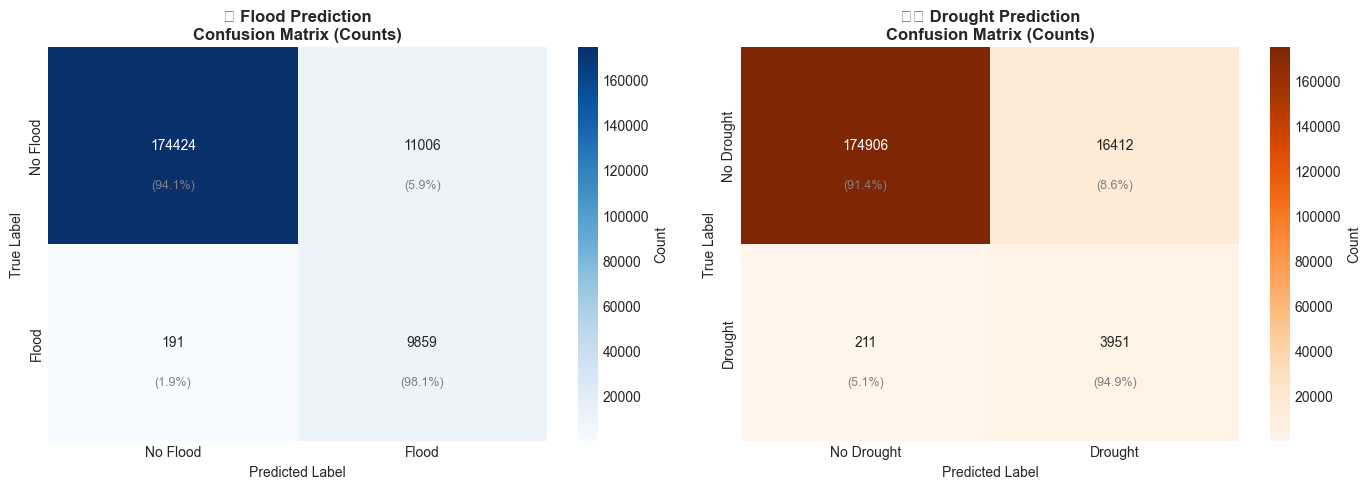


📊 Confusion Matrix Summary:

🌊 Flood:
   True Negatives (Correct No Flood): 174,424
   False Positives (False Alarm): 11,006
   False Negatives (Missed Flood): 191
   True Positives (Correct Flood): 9,859

🏜️ Drought:
   True Negatives (Correct No Drought): 174,906
   False Positives (False Alarm): 16,412
   False Negatives (Missed Drought): 211
   True Positives (Correct Drought): 3,951


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flood confusion matrix
cm_flood = confusion_matrix(results['flood_labels'], results['flood_preds'])
cm_flood_norm = cm_flood.astype('float') / cm_flood.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_flood, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('🌊 Flood Prediction\nConfusion Matrix (Counts)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

# Add percentages as secondary annotation
for i in range(2):
    for j in range(2):
        axes[0].text(j+0.5, i+0.7, f'({cm_flood_norm[i,j]*100:.1f}%)',
                    ha='center', va='center', fontsize=9, color='gray')

# Drought confusion matrix
cm_drought = confusion_matrix(results['drought_labels'], results['drought_preds'])
cm_drought_norm = cm_drought.astype('float') / cm_drought.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_drought, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['No Drought', 'Drought'],
            yticklabels=['No Drought', 'Drought'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('🏜️ Drought Prediction\nConfusion Matrix (Counts)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=10)
axes[1].set_ylabel('True Label', fontsize=10)

# Add percentages
for i in range(2):
    for j in range(2):
        axes[1].text(j+0.5, i+0.7, f'({cm_drought_norm[i,j]*100:.1f}%)',
                    ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, 'confusion_matrices_detailed.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n📊 Confusion Matrix Summary:")
print(f"\n🌊 Flood:")
print(f"   True Negatives (Correct No Flood): {cm_flood[0,0]:,}")
print(f"   False Positives (False Alarm): {cm_flood[0,1]:,}")
print(f"   False Negatives (Missed Flood): {cm_flood[1,0]:,}")
print(f"   True Positives (Correct Flood): {cm_flood[1,1]:,}")

print(f"\n🏜️ Drought:")
print(f"   True Negatives (Correct No Drought): {cm_drought[0,0]:,}")
print(f"   False Positives (False Alarm): {cm_drought[0,1]:,}")
print(f"   False Negatives (Missed Drought): {cm_drought[1,0]:,}")
print(f"   True Positives (Correct Drought): {cm_drought[1,1]:,}")

## 6. ROC and Precision-Recall Curves

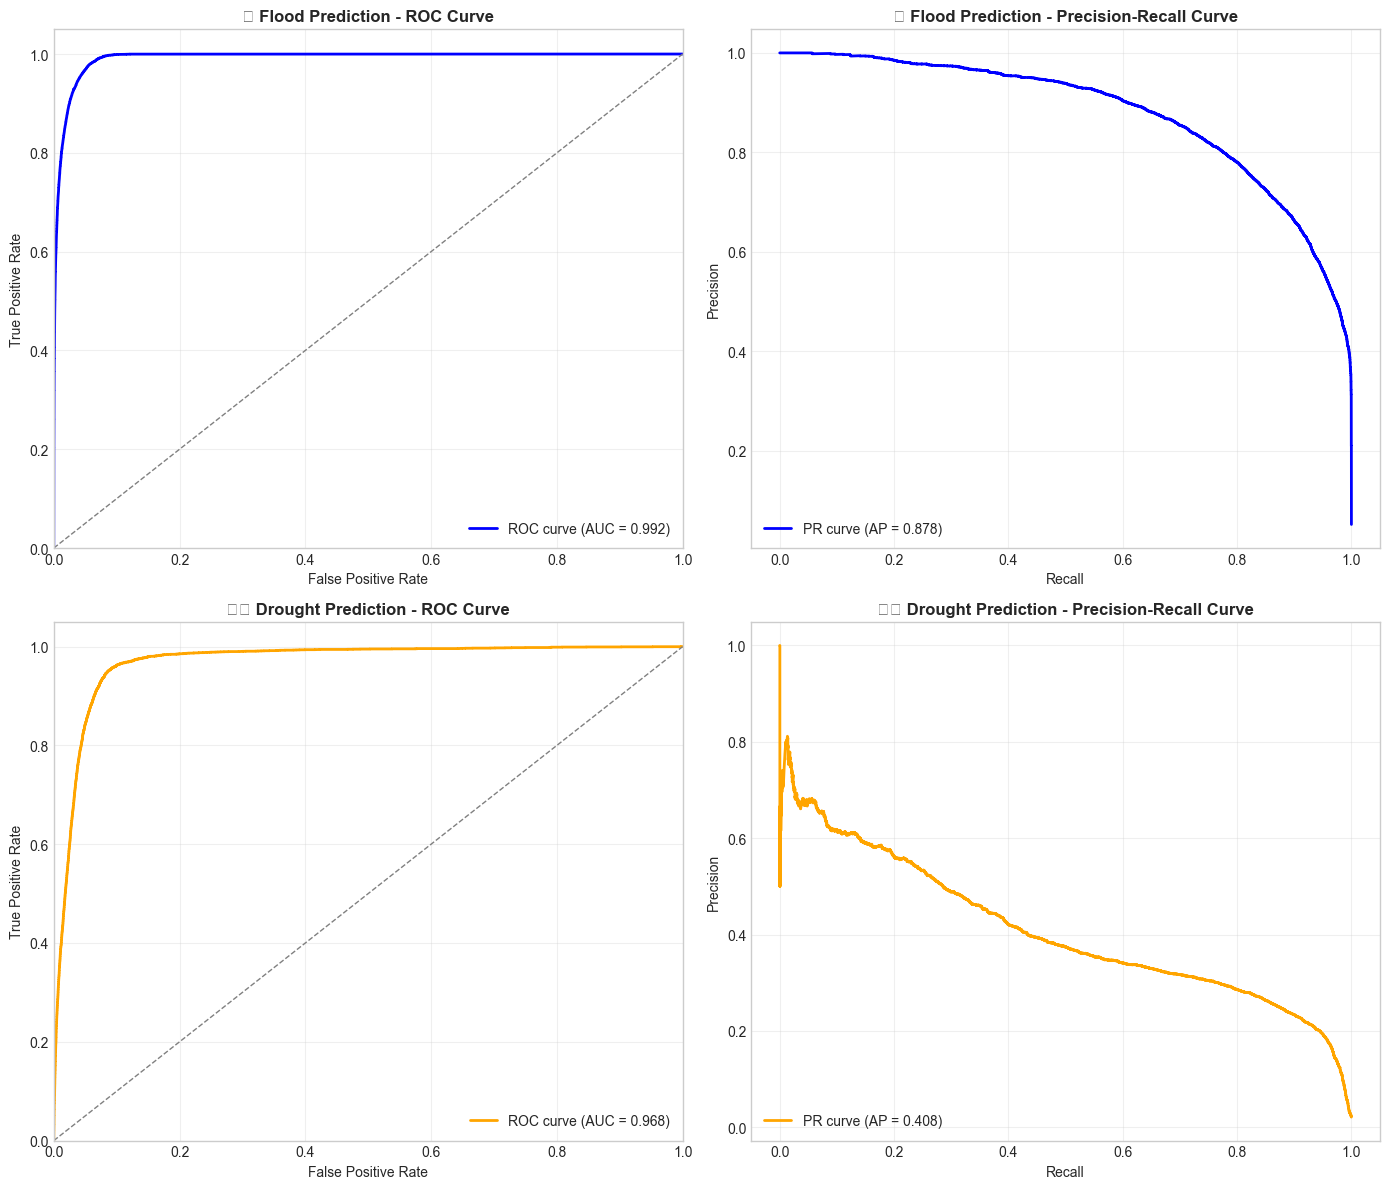


📈 AUC Scores:
   Flood ROC-AUC: 0.9918
   Flood Average Precision: 0.8780
   Drought ROC-AUC: 0.9682
   Drought Average Precision: 0.4078


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ===== FLOOD =====
# ROC Curve - Flood
fpr_flood, tpr_flood, _ = roc_curve(results['flood_labels'], results['flood_probs'])
auc_flood = roc_auc_score(results['flood_labels'], results['flood_probs'])

axes[0, 0].plot(fpr_flood, tpr_flood, color='blue', lw=2, 
                label=f'ROC curve (AUC = {auc_flood:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('🌊 Flood Prediction - ROC Curve', fontweight='bold')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curve - Flood
precision_flood, recall_flood, _ = precision_recall_curve(results['flood_labels'], results['flood_probs'])
ap_flood = average_precision_score(results['flood_labels'], results['flood_probs'])

axes[0, 1].plot(recall_flood, precision_flood, color='blue', lw=2,
                label=f'PR curve (AP = {ap_flood:.3f})')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('🌊 Flood Prediction - Precision-Recall Curve', fontweight='bold')
axes[0, 1].legend(loc="lower left")
axes[0, 1].grid(True, alpha=0.3)

# ===== DROUGHT =====
drought_probs_positive = results['drought_probs'][:, 1] if results['drought_probs'].ndim > 1 else results['drought_probs']

# ROC Curve - Drought
fpr_drought, tpr_drought, _ = roc_curve(results['drought_labels'], drought_probs_positive)
auc_drought = roc_auc_score(results['drought_labels'], drought_probs_positive)

axes[1, 0].plot(fpr_drought, tpr_drought, color='orange', lw=2,
                label=f'ROC curve (AUC = {auc_drought:.3f})')
axes[1, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('🏜️ Drought Prediction - ROC Curve', fontweight='bold')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(True, alpha=0.3)

# Precision-Recall Curve - Drought
precision_drought, recall_drought, _ = precision_recall_curve(results['drought_labels'], drought_probs_positive)
ap_drought = average_precision_score(results['drought_labels'], drought_probs_positive)

axes[1, 1].plot(recall_drought, precision_drought, color='orange', lw=2,
                label=f'PR curve (AP = {ap_drought:.3f})')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('🏜️ Drought Prediction - Precision-Recall Curve', fontweight='bold')
axes[1, 1].legend(loc="lower left")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, 'roc_pr_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📈 AUC Scores:")
print(f"   Flood ROC-AUC: {auc_flood:.4f}")
print(f"   Flood Average Precision: {ap_flood:.4f}")
print(f"   Drought ROC-AUC: {auc_drought:.4f}")
print(f"   Drought Average Precision: {ap_drought:.4f}")

## 7. Probability Distribution Analysis

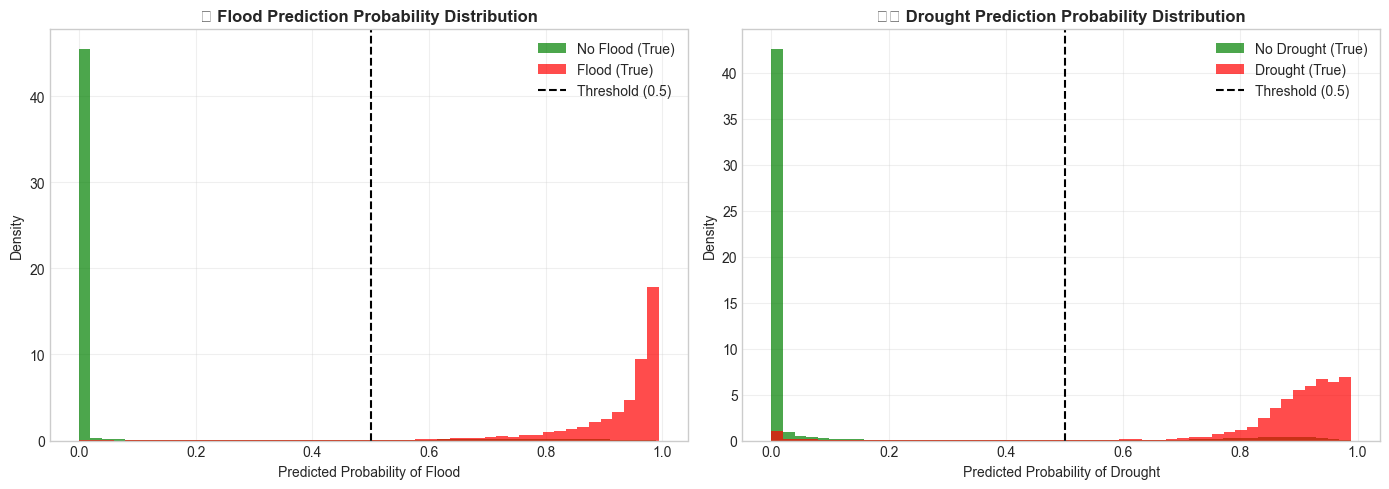

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flood probability distribution
axes[0].hist(results['flood_probs'][results['flood_labels'] == 0], bins=50, alpha=0.7, 
             label='No Flood (True)', color='green', density=True)
axes[0].hist(results['flood_probs'][results['flood_labels'] == 1], bins=50, alpha=0.7,
             label='Flood (True)', color='red', density=True)
axes[0].axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability of Flood')
axes[0].set_ylabel('Density')
axes[0].set_title('🌊 Flood Prediction Probability Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Drought probability distribution
axes[1].hist(drought_probs_positive[results['drought_labels'] == 0], bins=50, alpha=0.7,
             label='No Drought (True)', color='green', density=True)
axes[1].hist(drought_probs_positive[results['drought_labels'] == 1], bins=50, alpha=0.7,
             label='Drought (True)', color='red', density=True)
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability of Drought')
axes[1].set_ylabel('Density')
axes[1].set_title('🏜️ Drought Prediction Probability Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, 'probability_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [10]:
# Create error analysis dataframe
error_df = pd.DataFrame({
    'grid_id': results['grid_ids'],
    'date': results['dates'],
    'flood_true': results['flood_labels'],
    'flood_pred': results['flood_preds'],
    'flood_prob': results['flood_probs'],
    'drought_true': results['drought_labels'],
    'drought_pred': results['drought_preds'],
    'drought_prob': drought_probs_positive
})

# Add error flags
error_df['flood_error'] = error_df['flood_true'] != error_df['flood_pred']
error_df['drought_error'] = error_df['drought_true'] != error_df['drought_pred']
error_df['flood_false_negative'] = (error_df['flood_true'] == 1) & (error_df['flood_pred'] == 0)
error_df['flood_false_positive'] = (error_df['flood_true'] == 0) & (error_df['flood_pred'] == 1)
error_df['drought_false_negative'] = (error_df['drought_true'] == 1) & (error_df['drought_pred'] == 0)
error_df['drought_false_positive'] = (error_df['drought_true'] == 0) & (error_df['drought_pred'] == 1)

print("📊 Error Analysis Summary:")
print(f"\n🌊 Flood Errors:")
print(f"   Total errors: {error_df['flood_error'].sum():,} ({error_df['flood_error'].mean()*100:.2f}%)")
print(f"   False Negatives (Missed floods): {error_df['flood_false_negative'].sum():,}")
print(f"   False Positives (False alarms): {error_df['flood_false_positive'].sum():,}")

print(f"\n🏜️ Drought Errors:")
print(f"   Total errors: {error_df['drought_error'].sum():,} ({error_df['drought_error'].mean()*100:.2f}%)")
print(f"   False Negatives (Missed droughts): {error_df['drought_false_negative'].sum():,}")
print(f"   False Positives (False alarms): {error_df['drought_false_positive'].sum():,}")

📊 Error Analysis Summary:

🌊 Flood Errors:
   Total errors: 11,197 (5.73%)
   False Negatives (Missed floods): 191
   False Positives (False alarms): 11,006

🏜️ Drought Errors:
   Total errors: 16,623 (8.50%)
   False Negatives (Missed droughts): 211
   False Positives (False alarms): 16,412


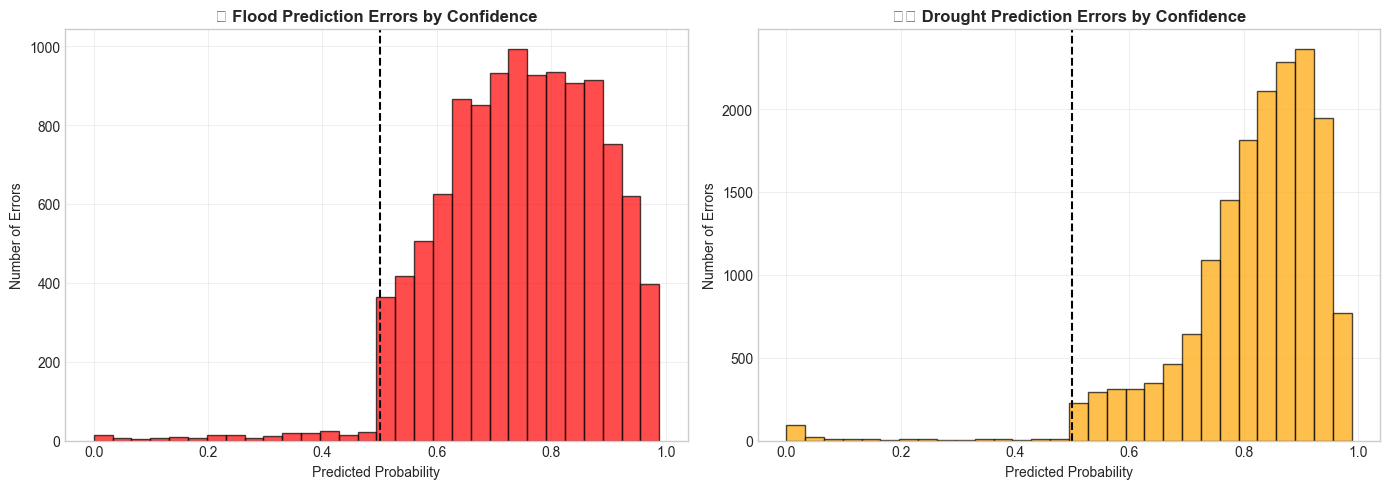


💡 Insight: Errors near threshold (0.5) are borderline cases where model is uncertain.
   High confidence errors indicate potential issues with certain patterns.


In [11]:
# Analyze errors by confidence level
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flood errors by confidence
flood_errors = error_df[error_df['flood_error']]
axes[0].hist(flood_errors['flood_prob'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Number of Errors')
axes[0].set_title('🌊 Flood Prediction Errors by Confidence', fontweight='bold')
axes[0].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[0].grid(True, alpha=0.3)

# Drought errors by confidence
drought_errors = error_df[error_df['drought_error']]
axes[1].hist(drought_errors['drought_prob'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Number of Errors')
axes[1].set_title('🏜️ Drought Prediction Errors by Confidence', fontweight='bold')
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, 'error_confidence_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Insight: Errors near threshold (0.5) are borderline cases where model is uncertain.")
print("   High confidence errors indicate potential issues with certain patterns.")

## 9. Threshold Analysis

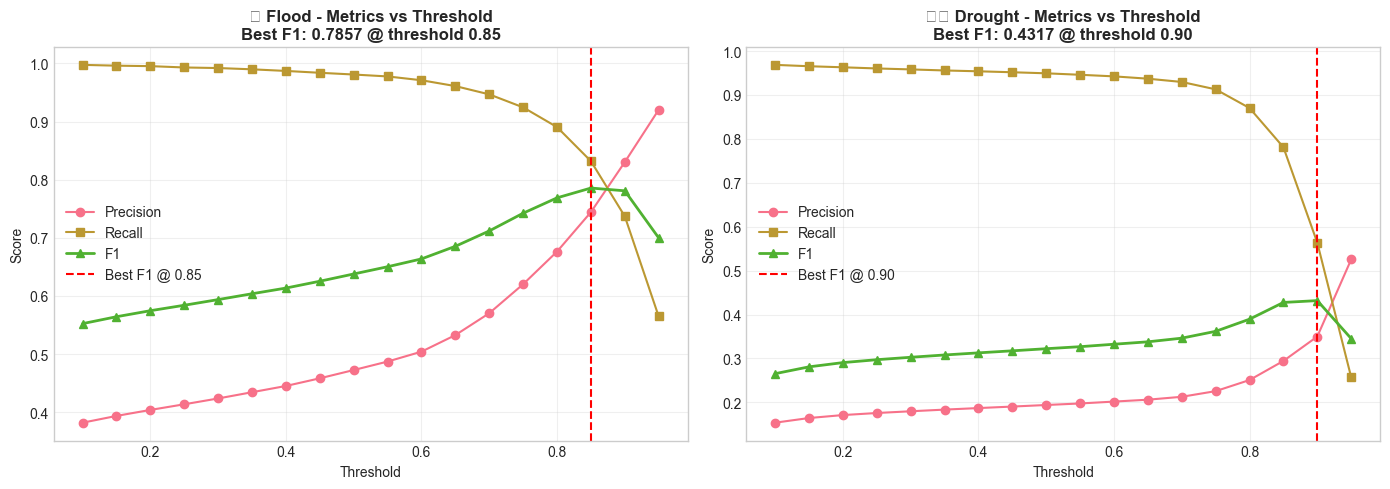


📊 Optimal Thresholds:
   Flood: 0.85 (F1: 0.7857)
   Drought: 0.90 (F1: 0.4317)


In [12]:
def analyze_thresholds(y_true, y_prob, task_name):
    """Analyze different classification thresholds"""
    thresholds = np.arange(0.1, 1.0, 0.05)
    metrics_by_threshold = []
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        metrics_by_threshold.append({
            'threshold': thresh,
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'accuracy': accuracy_score(y_true, y_pred)
        })
    
    df = pd.DataFrame(metrics_by_threshold)
    
    # Find optimal threshold for F1
    best_idx = df['f1'].idxmax()
    best_threshold = df.loc[best_idx, 'threshold']
    best_f1 = df.loc[best_idx, 'f1']
    
    return df, best_threshold, best_f1

# Analyze thresholds
flood_thresh_df, flood_best_thresh, flood_best_f1 = analyze_thresholds(
    results['flood_labels'], results['flood_probs'], 'Flood'
)
drought_thresh_df, drought_best_thresh, drought_best_f1 = analyze_thresholds(
    results['drought_labels'], drought_probs_positive, 'Drought'
)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flood
axes[0].plot(flood_thresh_df['threshold'], flood_thresh_df['precision'], label='Precision', marker='o')
axes[0].plot(flood_thresh_df['threshold'], flood_thresh_df['recall'], label='Recall', marker='s')
axes[0].plot(flood_thresh_df['threshold'], flood_thresh_df['f1'], label='F1', marker='^', linewidth=2)
axes[0].axvline(x=flood_best_thresh, color='red', linestyle='--', label=f'Best F1 @ {flood_best_thresh:.2f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title(f'🌊 Flood - Metrics vs Threshold\nBest F1: {flood_best_f1:.4f} @ threshold {flood_best_thresh:.2f}', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Drought
axes[1].plot(drought_thresh_df['threshold'], drought_thresh_df['precision'], label='Precision', marker='o')
axes[1].plot(drought_thresh_df['threshold'], drought_thresh_df['recall'], label='Recall', marker='s')
axes[1].plot(drought_thresh_df['threshold'], drought_thresh_df['f1'], label='F1', marker='^', linewidth=2)
axes[1].axvline(x=drought_best_thresh, color='red', linestyle='--', label=f'Best F1 @ {drought_best_thresh:.2f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title(f'🏜️ Drought - Metrics vs Threshold\nBest F1: {drought_best_f1:.4f} @ threshold {drought_best_thresh:.2f}', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, 'threshold_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Optimal Thresholds:")
print(f"   Flood: {flood_best_thresh:.2f} (F1: {flood_best_f1:.4f})")
print(f"   Drought: {drought_best_thresh:.2f} (F1: {drought_best_f1:.4f})")

## 10. Save Evaluation Results

In [13]:
# Compile all evaluation results
evaluation_results = {
    "evaluation_date": datetime.now().isoformat(),
    "test_samples": len(results['flood_labels']),
    "flood_metrics": {
        "accuracy": float(accuracy_score(results['flood_labels'], results['flood_preds'])),
        "precision": float(precision_score(results['flood_labels'], results['flood_preds'])),
        "recall": float(recall_score(results['flood_labels'], results['flood_preds'])),
        "f1": float(f1_score(results['flood_labels'], results['flood_preds'])),
        "roc_auc": float(auc_flood),
        "average_precision": float(ap_flood),
        "optimal_threshold": float(flood_best_thresh),
        "optimal_f1": float(flood_best_f1),
        "confusion_matrix": cm_flood.tolist()
    },
    "drought_metrics": {
        "accuracy": float(accuracy_score(results['drought_labels'], results['drought_preds'])),
        "precision": float(precision_score(results['drought_labels'], results['drought_preds'])),
        "recall": float(recall_score(results['drought_labels'], results['drought_preds'])),
        "f1": float(f1_score(results['drought_labels'], results['drought_preds'])),
        "roc_auc": float(auc_drought),
        "average_precision": float(ap_drought),
        "optimal_threshold": float(drought_best_thresh),
        "optimal_f1": float(drought_best_f1),
        "confusion_matrix": cm_drought.tolist()
    },
    "error_analysis": {
        "flood_total_errors": int(error_df['flood_error'].sum()),
        "flood_false_negatives": int(error_df['flood_false_negative'].sum()),
        "flood_false_positives": int(error_df['flood_false_positive'].sum()),
        "drought_total_errors": int(error_df['drought_error'].sum()),
        "drought_false_negatives": int(error_df['drought_false_negative'].sum()),
        "drought_false_positives": int(error_df['drought_false_positive'].sum())
    }
}

# Save to JSON
eval_path = os.path.join(LOG_DIR, f"{config.experiment_name}_evaluation.json")
with open(eval_path, 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print(f"✅ Evaluation results saved to {eval_path}")

# Save error dataframe for further analysis
error_df.to_csv(os.path.join(LOG_DIR, 'error_analysis.csv'), index=False)
print(f"✅ Error analysis saved to {os.path.join(LOG_DIR, 'error_analysis.csv')}")

✅ Evaluation results saved to /Users/leonnn/Desktop/DL for disaster/logs/disaster_prediction_v1_evaluation.json
✅ Error analysis saved to /Users/leonnn/Desktop/DL for disaster/logs/error_analysis.csv


## Summary

This evaluation notebook analyzed the disaster prediction model's performance:

1. **Classification Metrics**: Accuracy, Precision, Recall, F1 for both tasks
2. **Confusion Matrices**: Visualized true positives, false positives, etc.
3. **ROC & PR Curves**: Analyzed discrimination ability and precision-recall tradeoff
4. **Probability Distributions**: Examined model confidence for each class
5. **Error Analysis**: Identified patterns in misclassifications
6. **Threshold Optimization**: Found optimal classification thresholds

### Key Insights:
- Check the confusion matrices for class imbalance impact
- ROC-AUC indicates overall discrimination ability
- Optimal thresholds may differ from 0.5 for imbalanced classes
- False negatives (missed disasters) are more critical than false positives